<div style="text-align: left">CSYE 7370 Deep Learning and Reinforcement Learning in Game Engineering</div>
<div style="text-align: left">Yucong Feng, 001586064</div>
<div style="text-align: left">Assignment 1</div>

# Question:
Think of a real-world Bernoulli trial other than slots. Remember a Bernoulli trial (or binomial trial) is a random experiment with exactly two possible outcomes, "success" and "failure." This could click on a link or not click, buy or not buy etc. Get some data on the real range of probability for your real-world simulation. For example, how often does someone click on an ad?

Create the simulation and model it.  It is OK to use any code that you cite.  For example, from the notebook by Andre Cianflone - Thompson sampling https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb

 Optimize your Bandit Problem using Thompson Sampling, e-greedy, UBC, and random sampling.


# Answer:
## Bandit Problem:

This part is to model the initialization of the bandit problem and formulate rules. The following four sections simulate four different algorithms to solve the bandit problem:
1. Thompson Sampling
2. e-greedy
3. UBC 
4. random sampling 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace
import random

stationary=True
class Bandit():
    def __init__(self, arm_count):
        """
        Multi-armed bandit with rewards 1 or 0.

        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
        """
        self.arm_count = arm_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary=stationary
    
    def generate_thetas(self):
        self.thetas = np.random.uniform(0,1,self.arm_count)
  
    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
        """
        self.timestep += 1
        if (self.stationary==False) and (self.timestep%100 == 0) :
          self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0,1,self.arm_count)
        rewards = (sim<self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]

        return reward, regret

### Thompson Sampling

In [2]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()

class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


### Random Sampling

In [3]:
class RandomSampling(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'random'

    def get_action(self):
        # randomly choose machine
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

### Epsilon-Greedy

In [4]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### UCB

In [5]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### Modeling & Plot

The responsibility of this part is to model the simulated four algorithms and plot the output result.

In [6]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling] # adapted code
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

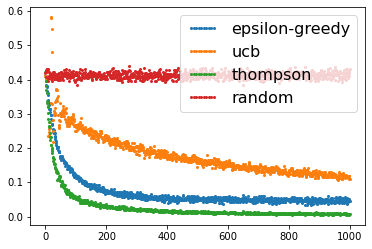

In [7]:
# Baseline
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

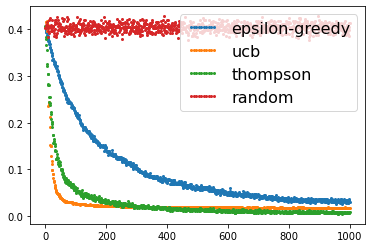

In [8]:
# Experiment 1 (smaller epsilon and c-value)
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

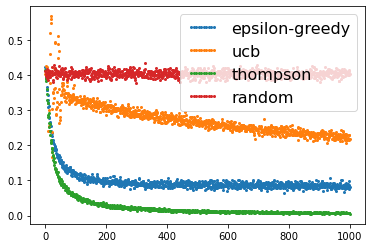

In [9]:
# Experiment 2 (bigger epsilon and c-value)
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 4
stationary= True
experiment(arm_count)

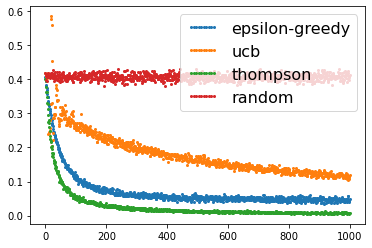

In [10]:
# Baseline
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

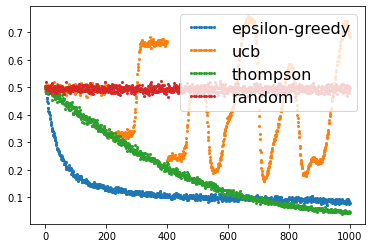

In [11]:
# Experiment 3 (actions: 10 -> 200)
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

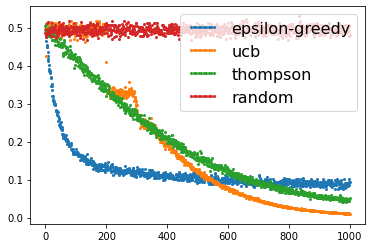

In [12]:
# Experiment 4 (actions: 10 -> 200 & value C: 2 -> 0.01)
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

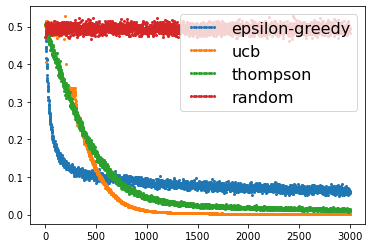

In [13]:
# Experiment 5 (actions: 10 -> 200 & value C: 2 -> 0.01 & timesteps: 1000 -> 3000)
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

**3. How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)**<br>

"We now reset our parameters to the baseline settings: 10-arm bandit,  and UCB-c value of 2. However, we now set the environment to being non-stationary. Actually, after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the -greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment."[1] **(Experiment 6)**

*[1] cited from https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb*

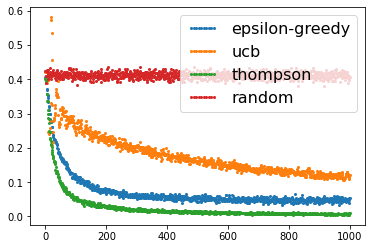

In [14]:
# Baseline
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

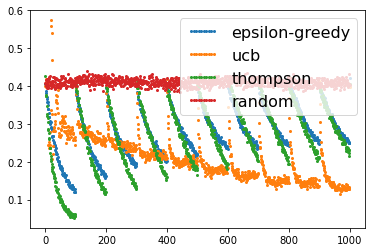

In [15]:
# Experiment 6 (stationary=False)
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

**6. Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)**<br>


In [16]:
# beta -> normal
class BernThompsonNormal():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

        self.record = [] # save the result of each round, n * m
        for i in range(0,self.arm_count):
            self.record.append([1]) # initialize every machine win once at the begining
    
        self.mean = np.ones(self.arm_count) # initialize mean = 1
        self.var = np.zeros(self.arm_count) # var = 0


    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.record[arm] = np.append(self.record[arm],reward) # save result
        self.mean[arm] = self.record[arm].mean() # calculate and save mean
        self.var[arm] = self.record[arm].var() # calculate and save var

    @staticmethod
    def name():
        return 'normal-thompson'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the normal distribution"""
        theta = np.random.normal(self.mean, self.var) # normal distribution
        return theta.argmax()

def experiment_(arm_count, timesteps=1000, simulations=1000):
    algos = [EpsilonGreedy, UCB, BernThompsonNormal, BernThompson, RandomSampling]
    regrets = []
    names = []
    for algo in algos:
      regrets.append(simulate(simulations, timesteps, arm_count, algo))
      names.append(algo.name())
    multi_plot_data(regrets, names)

In [17]:
# test
# b = np.ones((10,1),dtype = int)
# b[0] = np.append(b[0],2)
# b

a = []

for i in range(0,10):
    a.append([1])

a[0] = np.append(a[0],2)
a[0] = np.append(a[0],2)
a

[array([1, 2, 2]), [1], [1], [1], [1], [1], [1], [1], [1], [1]]

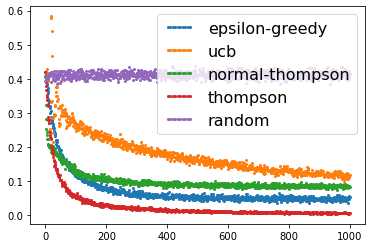

In [18]:
# Experiment 7 (add BernThompsonNormal)
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment_(arm_count)